# Task Description

- **Task Requirements:**  
  The objective of this task is to create a solution that enables the end user to visualize documents in a two-dimensional space and identify outliers. The workflow includes:
  - Converting the documents into chunks.
  - Converting the chunks into embeddings.
  - Standard scaling the embeddings.
  - Performing principal component analysis (PCA).
  - Applying dimensionality reduction.
  - Running K-means clustering to assign a cluster number to each chunk.
  - Creating an outlier flag.
  - Generating plots, such as:
    - A 2D visualization of embeddings.
    - Visualization colored by assigned clusters.
    - Visualization colored by the outlier flag.
    - Visualization colored by section number.

- **Dataset Description:**  
  - The dataset is sourced from the [HuggingFace edgar-corpus](https://huggingface.co/datasets/eloukas/edgar-corpus).
  - It contains 5480 rows (for year of 2020 and training split), with each row representing a unique company's filing (usually cik doesn't change), (also back-check by checking 5480 distinct `cik` values)
  - Each document in the dataset comprises 20 sections (from `section_1` ,`section_1A` `...`to `section_15`), all of which are parts of a 10-K filing (annual report).

- **Selection Strategy:**  
  Given that the task requires analyzing 10 companies' 10-K filings (annual reports), we will randomly sample 10 rows (i.e., 10 companies) from the dataset. This approach is justified since the dataset description confirms that the 15 sections represent the different parts of the annual report.
  
> **Note:** This strategy ensures that my analysis is focused on the filling type of 10-k with companies limit to 10, aligning with the task requirements and not over-scopped


In [1]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.5.5
      /_/
                        
Using Scala version 2.12.18, OpenJDK 64-Bit Server VM, 11.0.26
Branch HEAD
Compiled by user ubuntu on 2025-02-23T20:30:46Z
Revision 7c29c664cdc9321205a98a14858aaf8daaa19db2
Url https://github.com/apache/spark
Type --help for more information.


In [2]:
import sys
sys.path.append("utils")

import re
import math
import datasets

# Spark / Spark NLP
import sparknlp
from sparknlp.pretrained import PretrainedPipeline
from sparknlp.base import DocumentAssembler
from sparknlp.annotator import E5Embeddings

from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, size, udf, expr, split, rand, mean, stddev,
    percentile_approx, when
)
from pyspark.sql.types import ArrayType, StringType, FloatType
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import StandardScaler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator


# Local imports
from convert_dataset_to_spark import convert_dataset_to_spark_df
from section_processing import SectionProcessor
from plot_word_counts import plot_section_word_counts

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# TQDM progress
from tqdm.auto import tqdm


# Initialize & Load Data

In [3]:
# 1. Initialize Spark Session
spark = (
    SparkSession.builder
    .appName("EDGARCorpus")
    .master("local[*]")
    .config("spark.driver.memory", "16g")
    .config("spark.executor.memory", "32g")
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.5.3")
    .getOrCreate()
)

spark.sparkContext.setLogLevel("OFF")
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
spark.sparkContext.addPyFile("utils/section_processing.py")


:: loading settings :: url = jar:file:/Users/yuxiangwang/venv/lib/python3.13/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/yuxiangwang/.ivy2/cache
The jars for the packages stored in: /Users/yuxiangwang/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-4bacd1d1-bfbd-4234-88ae-2e8f238254d6;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;5.5.3 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-s3;1.12.500 in central
	found com.amazonaws#aws-java-sdk-kms;1.12.500 in central
	found com.amazonaws#aws-java-sdk-core;1.12.500 in central
	found commons-logging#commons-logging;1.1.3 in central
	found commons-codec#commons-codec;1.15 in central
	found org.apache.httpcomponents#httpclient;4.5.13 in central
	found org.apache.httpcomponents#httpcore;4.4.13 in central
	found software.amazon.ion#ion-java;1.0.2 in central
	found joda-time#joda-time;2.8.1 in central
	found com.amazonaws#jmespath-java;1.12.5

In [4]:
# 2. Load Data
dataset = datasets.load_dataset("eloukas/edgar-corpus", "year_2020", split="train")

In [5]:
# Convert the dataset to Spark DataFrame in multiple parquet batches
spark_df = convert_dataset_to_spark_df(
    dataset,
    spark,
    batch_size=300,
    output_dir="parquet_batches_task1"
)


Writing batches to Parquet:   0%|          | 0/5480 [00:00<?, ?it/s]

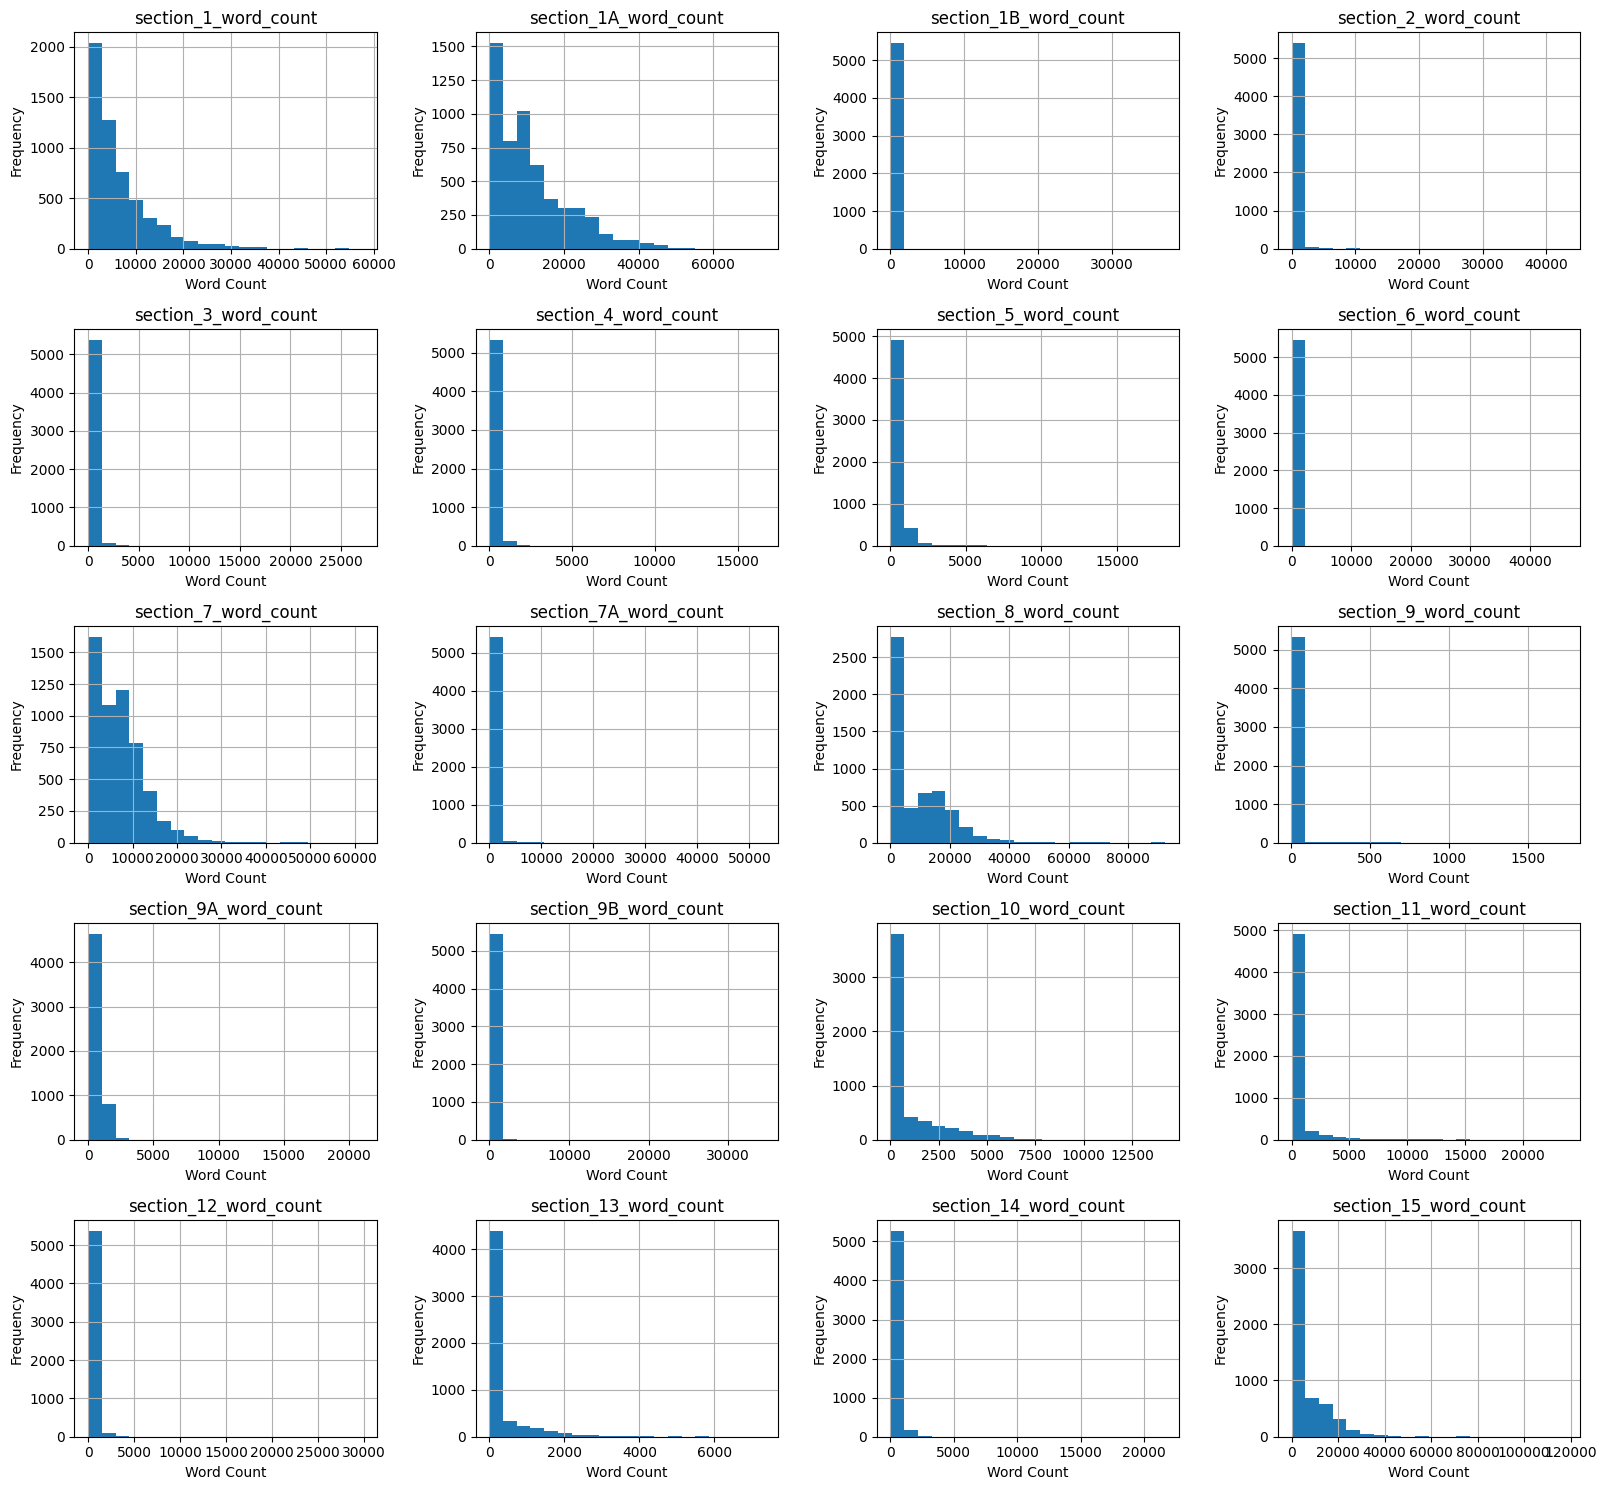

In [6]:
# visualize section word counts
plot_section_word_counts(spark_df, n_cols=4, bins=20, figsize_scale=3.0)

In [7]:
# 3. Take a random sample of 10 as task require
sampled_df = spark_df.orderBy(rand(seed=0)).limit(10)
sampled_df.cache()
_ = sampled_df.count() 

In [8]:
sampled_df

filename,cik,year,section_1,section_1A,section_1B,section_2,section_3,section_4,section_5,section_6,section_7,section_7A,section_8,section_9,section_9A,section_9B,section_10,section_11,section_12,section_13,section_14,section_15
1439288_2020.htm,1439288,2020,ITEM 1. BUSINESS....,ITEM 1A. RISK FAC...,ITEM 1B. UNRESOLV...,ITEM 2. PROPERTIE...,ITEM 3. LEGAL PRO...,ITEM 4. MINE SAFE...,ITEM 5. MARKET FO...,ITEM 6. SELECTED ...,ITEM 7. MANAGEMEN...,ITEM 7A. QUANTITA...,ITEM 8. FINANCIAL...,ITEM 9. CHANGES I...,ITEM 9A. CONTROLS...,ITEM 9B. OTHER IN...,ITEM 10. DIRECTOR...,ITEM 11. EXECUTIV...,ITEM 12. SECURITY...,ITEM 13. CERTAIN ...,ITEM 14. PRINCIPA...,ITEM 15. EXHIBITS...
1454742_2020.htm,1454742,2020,ITEM 1. BUSINESS\...,ITEM 1A. RISK FAC...,ITEM 1B. UNRESOLV...,ITEM 2. PROPERTIE...,ITEM 3. LEGAL PRO...,ITEM 4. MINE SAFE...,ITEM 5. MARKET FO...,ITEM 6. Selected ...,ITEM 7. Managemen...,ITEM 7A. QUANTITA...,ITEM 8. FINANCIAL...,ITEM 9. CHANGES I...,ITEM 9A. CONTROLS...,ITEM 9B. OTHER IN...,ITEM 10. DIRECTOR...,ITEM 11 EXECUTIVE...,ITEM 12 SECURITY ...,ITEM 13 CERTAIN R...,ITEM 14. PRINCIPA...,ITEM 15. EXHIBITS...
1655008_2020.htm,1655008,2020,Item 1. Business....,Item 1A. Risk Fac...,Item 1B. Unresolv...,Item 2. Propertie...,Item 3. Legal Pro...,Item 4. Mine Safe...,Item 5. Market fo...,Item 6. Selected ...,Item 7. Managemen...,Item 7A. Quantita...,Item 8. Financial...,Item 9. Changes i...,Item 9A. Controls...,Item 9B. Other In...,Item 10. Director...,Item 11. Executiv...,Item 12. Security...,Item 13. Certain ...,Item 14. Principa...,Item 15. Exhibits...
1637207_2020.htm,1637207,2020,Item 1. Business....,Item 1A. Risk Fac...,Item 1B. Unresolv...,Item 2. Propertie...,Item 3. Legal Pro...,Item 4. Mine Safe...,Item 5. Market fo...,Item 6. Selected ...,ITEM 7. Managemen...,ITEM 7A. Quantita...,Item 8. Financial...,Item 9. Changes i...,Item 9A. Controls...,Item 9B. Other In...,Item 10. Director...,Item 11. Executiv...,Item 12. Security...,Item 13. Certain ...,Item 14. Principa...,Item 15. Exhibits...
720762_2020.htm,720762,2020,Item 1. Business....,Item 1A. Risk Fac...,,Item 2. Propertie...,Item 3. Legal Pro...,Item 4. Mine Safe...,Item 5. Market fo...,Item 6. Selected ...,Item 7. Managemen...,Item 7A. Quantita...,Item 8. Financial...,Item 9. Changes i...,Item 9A(T). Contr...,Item 9B. Other In...,Item 10. Director...,Item 11. Executiv...,Item 12. Security...,Item 13. Certain ...,Item 14. Principa...,Item 15. Exhibits...
1376793_2020.htm,1376793,2020,ITEM 1. BUSINESS\...,ITEM 1A. RISK FAC...,ITEM 1B. UNRESOLV...,ITEM 2. PROPERTIE...,ITEM 3. LEGAL PRO...,ITEM 4. MINE SAFE...,ITEM 5. MARKET FO...,ITEM 6. SELECTED ...,ITEM 7. MANAGEMEN...,ITEM 7A. Quantita...,ITEM 8. FINANCIAL...,ITEM 9. CHANGES I...,ITEM 9A. CONTROLS...,ITEM 9B. Other In...,ITEM 10. Director...,ITEM 11. Executiv...,ITEM 12. Security...,ITEM 13. Certain ...,ITEM 14. Principa...,ITEM 15. EXHIBITS...
1377149_2020.htm,1377149,2020,ITEM 1. BUSINESS....,ITEM 1A. RISK FAC...,ITEM 1B. UNRESOLV...,ITEM 2. PROPERTIE...,ITEM 3. LEGAL PRO...,ITEM 4. MINE SAFE...,ITEM 5.\nMARKET F...,ITEM 6. SELECTED ...,ITEM 7. MANAGEMEN...,ITEM 7A. QUANTITA...,ITEM 8. FINANCIAL...,ITEM 9. CHANGES I...,ITEM 9A. CONTROLS...,ITEM 9B. OTHER IN...,ITEM 10. DIRECTOR...,ITEM 11. EXECUTIV...,ITEM 12. SECURITY...,ITEM 13. CERTAIN ...,ITEM 14. PRINCIPA...,ITEM 15. EXHIBITS...
1785493_2020.htm,1785493,2020,ITEM 1. BUSINESS\...,ITEM 1A. RISK FAC...,ITEM 1B. UNRESOLV...,ITEM 2. PROPERTIE...,ITEM 3. LEGAL PRO...,ITEM 4. MINE SAFE...,ITEM 5. MARKET FO...,ITEM 6. SELECTED ...,ITEM 7. MANAGEMEN...,ITEM 7A. QUANTITA...,ITEM 8. FINANCIAL...,ITEM 9. CHANGES I...,ITEM 9A. CONTROLS...,ITEM 9B. OTHER IN...,ITEM 10. DIRECTOR...,ITEM 11. EXECUTIV...,ITEM 12. SECURITY...,ITEM 13. CERTAIN ...,ITEM 14. PRINCIPA...,ITEM 15. EXHIBITS...
1507563_2020.htm,1507563,2020,Item 1. Business\...,Item 1A. Risk Fac...,Item 1B. Unresolv...,Item 2. Propertie...,Item 3. Legal Pro...,Item 4. Mine Safe...,Item 5. Market fo...,Item 6. Selected

#  Convert Documents into Chunks

In [9]:
# 4. Convert Documents into Chunks

processor = SectionProcessor(max_words=300, overlap=1)

processed_df = processor.process_all_sections(
    sampled_df, 
    show_progress=True,
    force_action=True
)

chunk_cols = [c for c in processed_df.columns if "_chunk_" in c]
print(f"Found {len(chunk_cols)} chunk columns.")

Processing sections:   0%|          | 0/20 [00:00<?, ?it/s]

Found 462 chunk columns.


In [10]:
# Stack chunk columns into long format: (chunk_col_name, text)
stack_expr = "stack({0}, {1}) as (chunk_col_name, text)".format(
    len(chunk_cols),
    ", ".join([f"'{col}', {col}" for col in chunk_cols])
)

df_long = processed_df.select("cik", "year", expr(stack_expr))
df_long = df_long.filter(df_long["text"].isNotNull())

df_long.printSchema()
df_long.cache()
_ = df_long.count()

root
 |-- cik: string (nullable = true)
 |-- year: string (nullable = true)
 |-- chunk_col_name: string (nullable = true)
 |-- text: string (nullable = true)



In [11]:
df_long

cik,year,chunk_col_name,text
1439288,2020,section_1_chunk_1,ITEM 1. BUSINESS....
1439288,2020,section_1_chunk_2,Our Process & Mot...
1439288,2020,section_1_chunk_3,We are led by an ...
1439288,2020,section_1_chunk_4,and (4) a culture...
1439288,2020,section_1_chunk_5,We believe this r...
1439288,2020,section_1_chunk_6,Our products are ...
1439288,2020,section_1_chunk_7,We believe we hav...
1439288,2020,section_1_chunk_8,Our Markets\nWe e...
1439288,2020,section_1_chunk_9,"In addition, thro..."
1439288,2020,section_1_chunk_10,We believe that w...


# Convert Chunks to Embeddings

In [12]:
# Create a single pipeline with DocumentAssembler + E5 embeddings
document_assembler = DocumentAssembler().setInputCol("text").setOutputCol("document")
embedding = E5Embeddings.pretrained("e5_large", "en") \
    .setInputCols(["document"]) \
    .setOutputCol("embeddings")

pipeline = Pipeline().setStages([document_assembler, embedding])

# because E5Embeddings does not actually learn from data in the pipeline.
fit_sample_df = df_long.limit(1)
pipeline_model = pipeline.fit(fit_sample_df)


e5_large download started this may take some time.
Approximate size to download 759.2 MB
e5_large download started this may take some time.
Approximate size to download 759.2 MB
Download done! Loading the resource.
[ / ]

[OK!]


In [13]:
def transform_embeddings(input_df, pipeline_model):
    """
    Transform the input_df using a pre-fitted pipeline_model.
    Extract the embedding array into a Spark ML Vector column 'embeddings_vector'.
    """
    transformed_df = pipeline_model.transform(input_df)
    
    # UDF to convert python array -> Spark ML DenseVector
    def array_to_vector(arr):
        return Vectors.dense(arr) if arr else Vectors.dense([])
    to_vector_udf = udf(array_to_vector, VectorUDT())
    
    # Extract embeddings from the annotation
    df_embeddings = (
        transformed_df
        .withColumn("embeddings_array", expr("transform(embeddings, x -> x.embeddings)[0]"))
        .withColumn("embeddings_vector", to_vector_udf("embeddings_array"))
        .select("cik", "year", "chunk_col_name", "text", "embeddings_vector")
    )
    
    return df_embeddings

In [14]:
df_embeddings = transform_embeddings(df_long, pipeline_model)

In [15]:
df_embeddings.printSchema()
df_embeddings.cache()
_ = df_embeddings.count()

root
 |-- cik: string (nullable = true)
 |-- year: string (nullable = true)
 |-- chunk_col_name: string (nullable = true)
 |-- text: string (nullable = true)
 |-- embeddings_vector: vector (nullable = true)



[Stage 164:>                                                        (0 + 1) / 1]

Using CPUs


In [16]:
df_embeddings

cik,year,chunk_col_name,text,embeddings_vector
1439288,2020,section_1_chunk_1,ITEM 1. BUSINESS....,[0.02043371833860...
1439288,2020,section_1_chunk_2,Our Process & Mot...,[0.00304083013907...
1439288,2020,section_1_chunk_3,We are led by an ...,[0.00197939248755...
1439288,2020,section_1_chunk_4,and (4) a culture...,[0.02122941426932...
1439288,2020,section_1_chunk_5,We believe this r...,[0.00123491184785...
1439288,2020,section_1_chunk_6,Our products are ...,[-0.0048844791017...
1439288,2020,section_1_chunk_7,We believe we hav...,[-0.0070496592670...
1439288,2020,section_1_chunk_8,Our Markets\nWe e...,[1.67781108757480...
1439288,2020,section_1_chunk_9,"In addition, thro...",[0.01051829103380...
1439288,2020,section_1_chunk_10,We believe that w...,[-0.0027142362669...


# Standard Scale the Embeddings

In [17]:
# 6. Standard Scale the Embeddings

scaler = StandardScaler(
    inputCol="embeddings_vector", 
    outputCol="scaled_embeddings", 
    withMean=True, 
    withStd=True
)

In [18]:
scaler_model = scaler.fit(df_embeddings)

In [19]:
df_scaled = scaler_model.transform(df_embeddings)

In [20]:
df_scaled.printSchema()
df_scaled.cache()
_ = df_scaled.count()

root
 |-- cik: string (nullable = true)
 |-- year: string (nullable = true)
 |-- chunk_col_name: string (nullable = true)
 |-- text: string (nullable = true)
 |-- embeddings_vector: vector (nullable = true)
 |-- scaled_embeddings: vector (nullable = true)



In [21]:
df_scaled

cik,year,chunk_col_name,text,embeddings_vector,scaled_embeddings
1439288,2020,section_1_chunk_1,ITEM 1. BUSINESS....,[0.02043371833860...,[1.99050095662707...
1439288,2020,section_1_chunk_2,Our Process & Mot...,[0.00304083013907...,[0.58412019392248...
1439288,2020,section_1_chunk_3,We are led by an ...,[0.00197939248755...,[0.49829284444635...
1439288,2020,section_1_chunk_4,and (4) a culture...,[0.02122941426932...,[2.05484055549575...
1439288,2020,section_1_chunk_5,We believe this r...,[0.00123491184785...,[0.43809448993140...
1439288,2020,section_1_chunk_6,Our products are ...,[-0.0048844791017...,[-0.0567165852771...
1439288,2020,section_1_chunk_7,We believe we hav...,[-0.0070496592670...,[-0.2317920355049...
1439288,2020,section_1_chunk_8,Our Markets\nWe e...,[1.67781108757480...,[0.35180680006953...
1439288,2020,section_1_chunk_9,"In addition, thro...",[0.01051829103380...,[1.18874416640962...
1439288,2020,section_1_chunk_10,We believe that w...,[-0.0027142362669...,[0.11876823002754...


# Principal Component Analysis (PCA)

In [22]:
# 7. Principal Component Analysis (PCA)

num_components = 1024  # e5 return 1024-d
pca_full = PCA(
    k=num_components,
    inputCol="scaled_embeddings",
    outputCol="temp_pca"
)
pca_full_model = pca_full.fit(df_scaled)

In [23]:
explained_variance = pca_full_model.explainedVariance.toArray().tolist()

In [24]:
# Find how many components are needed for ~95% variance
target_threshold = 0.90
cumulative_variance = 0.0
required_components = 0

for i, var in enumerate(explained_variance):
    cumulative_variance += var
    if cumulative_variance >= target_threshold:
        required_components = i + 1  # +1 because enumerate is 0-based
        break

print(f"To reach {target_threshold*100}% variance, ~{required_components} components are needed.")
print(f"Cumulative explained variance: {cumulative_variance:.4f}")


To reach 90.0% variance, ~217 components are needed.
Cumulative explained variance: 0.9002


# Apply dimensionality reduction

In [25]:
# Re-run PCA for clustering with only required_components
pca_clustering = PCA(
    k=required_components,
    inputCol="scaled_embeddings",
    outputCol="pca_features"
)
pca_clustering_model = pca_clustering.fit(df_scaled)
df_intermediate = pca_clustering_model.transform(df_scaled)


In [26]:
# Also do PCA with k=2 for 2D plots
pca_plot = PCA(k=2, inputCol="scaled_embeddings", outputCol="pca2d")
pca_plot_model = pca_plot.fit(df_scaled)
df_final = pca_plot_model.transform(df_intermediate)


In [27]:
df_final.printSchema()
df_final.cache()
_ = df_final.count()

root
 |-- cik: string (nullable = true)
 |-- year: string (nullable = true)
 |-- chunk_col_name: string (nullable = true)
 |-- text: string (nullable = true)
 |-- embeddings_vector: vector (nullable = true)
 |-- scaled_embeddings: vector (nullable = true)
 |-- pca_features: vector (nullable = true)
 |-- pca2d: vector (nullable = true)



In [28]:
df_final

cik,year,chunk_col_name,text,embeddings_vector,scaled_embeddings,pca_features,pca2d
1439288,2020,section_1_chunk_1,ITEM 1. BUSINESS....,[0.02043371833860...,[1.99050095662707...,[9.08763558891871...,[9.08763558891871...
1439288,2020,section_1_chunk_2,Our Process & Mot...,[0.00304083013907...,[0.58412019392248...,[13.3379094769699...,[13.3379094769699...
1439288,2020,section_1_chunk_3,We are led by an ...,[0.00197939248755...,[0.49829284444635...,[-0.6093248582511...,[-0.6093248582511...
1439288,2020,section_1_chunk_4,and (4) a culture...,[0.02122941426932...,[2.05484055549575...,[6.33972768395289...,[6.33972768395289...
1439288,2020,section_1_chunk_5,We believe this r...,[0.00123491184785...,[0.43809448993140...,[7.17026441482496...,[7.17026441482496...
1439288,2020,section_1_chunk_6,Our products are ...,[-0.0048844791017...,[-0.0567165852771...,[8.72487468318937...,[8.72487468318937...
1439288,2020,section_1_chunk_7,We believe we hav...,[-0.0070496592670...,[-0.2317920355049...,[11.6069223454197...,[11.6069223454197...
1439288,2020,section_1_chunk_8,Our Markets\nWe e...,[1.67781108757480...,[0.35180680006953...,[10.3619267966205...,[10.3619267966205...
1439288,2020,section_1_chunk_9,"In addition, thro...",[0.01051829103380...,[1.18874416640962...,[11.8781113635962...,[11.8781113635962...
1439288,2020,section_1_chunk_10,We believe that w...,[-0.0027142362669...,[0.11876823002754...,[11.8496077839471...,[11.8496077839471...


# Perform Kmeans clustering and assign chunks an cluster number

In [29]:
# 8. KMeans Clustering & Silhouette Evaluation

ks = [5, 8, 10, 12, 14, 15, 18, 20, 22, 24]
silhouettes = []
best_k = None
best_sil = -1.0

print("\nEvaluating KMeans with different k:")
for k in tqdm(ks):
    kmeans = KMeans(k=k, featuresCol="pca_features", seed=42)
    model = kmeans.fit(df_final)
    df_clustered_k = model.transform(df_final)
    
    evaluator = ClusteringEvaluator(
        featuresCol="pca_features",
        predictionCol="prediction",
        metricName="silhouette"
    )
    silhouette = evaluator.evaluate(df_clustered_k)
    silhouettes.append((k, silhouette))
    if silhouette > best_sil:
        best_sil = silhouette
        best_k = k

# Display silhouette results
for k_val, s_val in silhouettes:
    print(f"  k={k_val}, silhouette={s_val:.4f}")
print(f"\nBest k={best_k} with silhouette={best_sil:.4f}")


Evaluating KMeans with different k:


  0%|          | 0/10 [00:00<?, ?it/s]

  k=5, silhouette=0.0867
  k=8, silhouette=0.1042
  k=10, silhouette=0.1013
  k=12, silhouette=0.0951
  k=14, silhouette=0.1193
  k=15, silhouette=0.1181
  k=18, silhouette=0.1138
  k=20, silhouette=0.1181
  k=22, silhouette=0.1192
  k=24, silhouette=0.1066

Best k=14 with silhouette=0.1193


In [30]:
# Use the best_k for final model
kmeans_final = KMeans(
    k=best_k,
    featuresCol="pca_features",
    predictionCol="cluster_id",
    seed=42
)
kmeans_model_final = kmeans_final.fit(df_final)
df_clustered = kmeans_model_final.transform(df_final)

In [31]:
df_clustered.printSchema()
df_clustered.cache()
_ = df_clustered.count()


root
 |-- cik: string (nullable = true)
 |-- year: string (nullable = true)
 |-- chunk_col_name: string (nullable = true)
 |-- text: string (nullable = true)
 |-- embeddings_vector: vector (nullable = true)
 |-- scaled_embeddings: vector (nullable = true)
 |-- pca_features: vector (nullable = true)
 |-- pca2d: vector (nullable = true)
 |-- cluster_id: integer (nullable = false)



In [32]:
df_clustered

cik,year,chunk_col_name,text,embeddings_vector,scaled_embeddings,pca_features,pca2d,cluster_id
1439288,2020,section_1_chunk_1,ITEM 1. BUSINESS....,[0.02043371833860...,[1.99050095662707...,[9.08763558891871...,[9.08763558891871...,13
1439288,2020,section_1_chunk_2,Our Process & Mot...,[0.00304083013907...,[0.58412019392248...,[13.3379094769699...,[13.3379094769699...,13
1439288,2020,section_1_chunk_3,We are led by an ...,[0.00197939248755...,[0.49829284444635...,[-0.6093248582511...,[-0.6093248582511...,13
1439288,2020,section_1_chunk_4,and (4) a culture...,[0.02122941426932...,[2.05484055549575...,[6.33972768395289...,[6.33972768395289...,13
1439288,2020,section_1_chunk_5,We believe this r...,[0.00123491184785...,[0.43809448993140...,[7.17026441482496...,[7.17026441482496...,13
1439288,2020,section_1_chunk_6,Our products are ...,[-0.0048844791017...,[-0.0567165852771...,[8.72487468318937...,[8.72487468318937...,13
1439288,2020,section_1_chunk_7,We believe we hav...,[-0.0070496592670...,[-0.2317920355049...,[11.6069223454197...,[11.6069223454197...,13
1439288,2020,section_1_chunk_8,Our Markets\nWe e...,[1.67781108757480...,[0.35180680006953...,[10.3619267966205...,[10.3619267966205...,13
1439288,2020,section_1_chunk_9,"In addition, thro...",[0.01051829103380...,[1.18874416640962...,[11.8781113635962...,[11.8781113635962...,13
1439288,2020,section_1_chunk_10,We believe that w...,[-0.0027142362669...,[0.11876823002754...,[11.8496077839471...,[11.8496077839471...,13


# Create an outlier flag.

In [33]:
def compute_outlier_flags(df_clustered, kmeans_model, alpha=2.0, iqr_multiplier=1.5):
    """
    Given:
        df_clustered: A Spark DataFrame with columns:
            - 'pca_features' (DenseVector),
            - 'cluster_id' (int from KMeans prediction)
        kmeans_model: A fitted KMeansModel with .clusterCenters()
        alpha: Multiplier for the mean+std outlier rule (default=2.0)
        iqr_multiplier: Multiplier for the IQR outlier rule (default=1.5)
    
    Returns:
        A new Spark DataFrame with:
            - dist_to_center (float)
            - mean_dist, std_dist, quartiles (array [Q1, Q3]) by cluster
            - Q1, Q3, IQR, upper_iqr
            - is_outlier_std (bool)
            - is_outlier_iqr (bool)
    """

    # 1) Broadcast cluster centers for the UDF
    centers = kmeans_model.clusterCenters()
    bc_centers = df_clustered.sparkSession.sparkContext.broadcast(centers)

    # 2) UDF to compute Euclidean distance from pca_features to cluster center
    def distance_to_center(vec, cluster_id):
        arr = vec.toArray()
        center = bc_centers.value[cluster_id]
        dist_sq = sum((arr[i] - center[i])**2 for i in range(len(center)))
        return float(math.sqrt(dist_sq))
    
    dist_udf = udf(distance_to_center, FloatType())

    # 3) Append column "dist_to_center"
    df_with_dist = df_clustered.withColumn(
        "dist_to_center",
        dist_udf(col("pca_features"), col("cluster_id"))
    )

    # 4) Compute cluster-level stats: mean, stddev, and quartiles (Q1, Q3)
    cluster_stats = df_with_dist.groupBy("cluster_id").agg(
        mean("dist_to_center").alias("mean_dist"),
        stddev("dist_to_center").alias("std_dist"),
        percentile_approx("dist_to_center", [0.25, 0.75]).alias("quartiles")
    )

    # 5) Join the stats back
    df_joined = df_with_dist.join(cluster_stats, on="cluster_id", how="left")

    # 6) Compute outlier flags (both std-based and IQR-based) in one chain
    df_outliers = (
        df_joined
        # Extract Q1, Q3 from quartiles array
        .withColumn("Q1", col("quartiles").getItem(0))
        .withColumn("Q3", col("quartiles").getItem(1))
        .withColumn("IQR", col("Q3") - col("Q1"))
        .withColumn("upper_iqr", col("Q3") + iqr_multiplier * col("IQR"))

        # Outlier if distance > mean + alpha×std
        .withColumn(
            "is_outlier_std",
            (col("dist_to_center") > (col("mean_dist") + alpha * col("std_dist"))).cast("boolean")
        )
        # Outlier if distance > (Q3 + iqr_multiplier×IQR)
        .withColumn(
            "is_outlier_iqr",
            (col("dist_to_center") > col("upper_iqr")).cast("boolean")
        )
    )

    return df_outliers

In [34]:
df_outliers = compute_outlier_flags(df_clustered, kmeans_model_final)

In [35]:
df_outliers.printSchema()
df_outliers.cache()
_ = df_outliers.count()

root
 |-- cluster_id: integer (nullable = false)
 |-- cik: string (nullable = true)
 |-- year: string (nullable = true)
 |-- chunk_col_name: string (nullable = true)
 |-- text: string (nullable = true)
 |-- embeddings_vector: vector (nullable = true)
 |-- scaled_embeddings: vector (nullable = true)
 |-- pca_features: vector (nullable = true)
 |-- pca2d: vector (nullable = true)
 |-- dist_to_center: float (nullable = true)
 |-- mean_dist: double (nullable = true)
 |-- std_dist: double (nullable = true)
 |-- quartiles: array (nullable = true)
 |    |-- element: float (containsNull = false)
 |-- Q1: float (nullable = true)
 |-- Q3: float (nullable = true)
 |-- IQR: float (nullable = true)
 |-- upper_iqr: double (nullable = true)
 |-- is_outlier_std: boolean (nullable = true)
 |-- is_outlier_iqr: boolean (nullable = true)



In [36]:
df_outliers

cluster_id,cik,year,chunk_col_name,text,embeddings_vector,scaled_embeddings,pca_features,pca2d,dist_to_center,mean_dist,std_dist,quartiles,Q1,Q3,IQR,upper_iqr,is_outlier_std,is_outlier_iqr
13,1439288,2020,section_1_chunk_1,ITEM 1. BUSINESS....,[0.02043371833860...,[1.99050095662707...,[9.08763558891871...,[9.08763558891871...,28.552717,30.25765895843506,2.262199811498192,"[28.302229, 31.81...",28.302229,31.81889,3.5166607,37.09388065338135,false,false
13,1439288,2020,section_1_chunk_2,Our Process & Mot...,[0.00304083013907...,[0.58412019392248...,[13.3379094769699...,[13.3379094769699...,29.63973,30.25765895843506,2.262199811498192,"[28.302229, 31.81...",28.302229,31.81889,3.5166607,37.09388065338135,false,false
13,1439288,2020,section_1_chunk_3,We are led by an ...,[0.00197939248755...,[0.49829284444635...,[-0.6093248582511...,[-0.6093248582511...,28.01645,30.25765895843506,2.262199811498192,"[28.302229, 31.81...",28.302229,31.81889,3.5166607,37.09388065338135,false,false
13,1439288,2020,section_1_chunk_4,and (4) a culture...,[0.02122941426932...,[2.05484055549575...,[6.33972768395289...,[6.33972768395289...,27.575748,30.25765895843506,2.262199811498192,"[28.302229, 31.81...",28.302229,31.81889,3.5166607,37.09388065338135,false,false
13,1439288,2020,section_1_chunk_5,We believe this r...,[0.00123491184785...,[0.43809448993140...,[7.17026441482496...,[7.17026441482496...,26.665974,30.25765895843506,2.262199811498192,"[28.302229, 31.81...",28.302229,31.81889,3.5166607,37.09388065338135,false,false
13,1439288,2020,section_1_chunk_6,Our products are ...,[-0.0048844791017...,[-0.0567165852771...,[8.72487468318937...,[8.72487468318937...,28.44604,30.25765895843506,2.262199811498192,"[28.302229, 31.81...",28.302229,31.81889,3.5166607,37.09388065338135,false,false
13,1439288,2020,section_1_chunk_7,We believe we hav...,[-0.0070496592670...,[-0.2317920355049...,[11.6069223454197...,[11.6069223454197...,28.918753,30.25765895843506,2.262199811498192,"[28.302229, 31.81...",28.302229,31.81889,3.5166607,37.09388065338135,false,false
13,1439288,2020,section_1_chunk_8,Our Markets\nWe e...,[1.67781108757480...,[0.35180680006953...,[10.3619267966205...,[10.3619267966205...,31.299635,30.25765895843506,2.262199811498192,"[28.302229, 31.81...",28.302229,31.81889,3.5166607,37.09388065338135,false,false
13,1439288,2020,section_1_chunk_9,"In addition, thro...",[0.01051829103380...,[1.18874416640962...,[11.8781113635962...,[11.8781113635962...,30.809431,30.25765895843506,2.262199811498192,"[28.302229, 31.81...",28.302229,31.81889,3.5166607,37.09388065338135,false,false
13,1439288,2020,section_1_chunk_10,We believe that w...,[-0.0027142362669...,[0.11876823002754...,[11.8496077839471...,[11.8496077839471...,32.470722,30.25765895843506,2.262199811498192,"[28.302229, 31.81...",28.302229,31.81889,3.5166607,37.09388065338135,false,false


# Plot(s)

In [37]:
# 10. Plotting
pdf = df_outliers.select("pca2d", "cluster_id", "is_outlier_iqr", "chunk_col_name").toPandas()
pdf["x"] = pdf["pca2d"].apply(lambda v: float(v[0]))
pdf["y"] = pdf["pca2d"].apply(lambda v: float(v[1]))


In [38]:
def extract_section(raw_name):
    """
    Extract the substring between 'section_' and '_chunk_'.
    """
    match = re.search(r"section_([^_]+)_chunk_", str(raw_name))
    return match.group(1) if match else "Unknown"

pdf["section_label"] = pdf["chunk_col_name"].apply(extract_section)

In [39]:
pdf

,pca2d,cluster_id,is_outlier_iqr,chunk_col_name,x,y,section_label
0,"[9.087635588918713, 3.3830605028265626]",13,False,section_1_chunk_1,9.087636,3.383061,1
1,"[13.33790947696992, 7.33083909989321]",13,False,section_1_chunk_2,13.337909,7.330839,1
2,"[-0.6093248582511219, 2.7473159447735584]",13,False,section_1_chunk_3,-0.609325,2.747316,1
3,"[6.339727683952891, 6.588069459692104]",13,False,section_1_chunk_4,6.339728,6.588069,1
4,"[7.170264414824961, 7.630977899434001]",13,False,section_1_chunk_5,7.170264,7.630978,1
...,...,...,...,...,...,...,...
1561,"[-11.883044761373087, -1.4736865460433446]",2,False,section_15_chunk_58,-11.883045,-1.473687,15
1562,"[4.910853100785074, -0.7229689027468339]",7,True,section_15_chunk_59,4.910853,-0.722969,15
1563,"[-4.229095591401257, -2.7896552997103465]",7,False,section_15_chunk_60,-4.229096,-2.789655,15
1564,"[-5.0160442563867305, -2.0288127066306783]",7,False,section_15_chunk_61,-5.016044,-2.028813,15


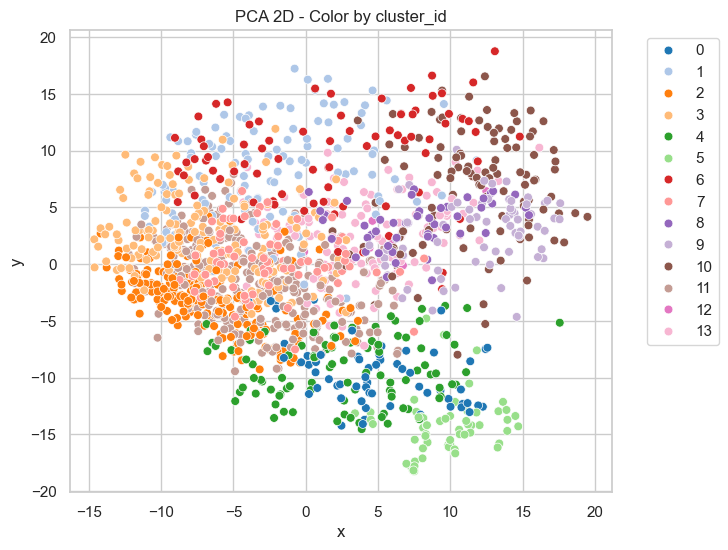

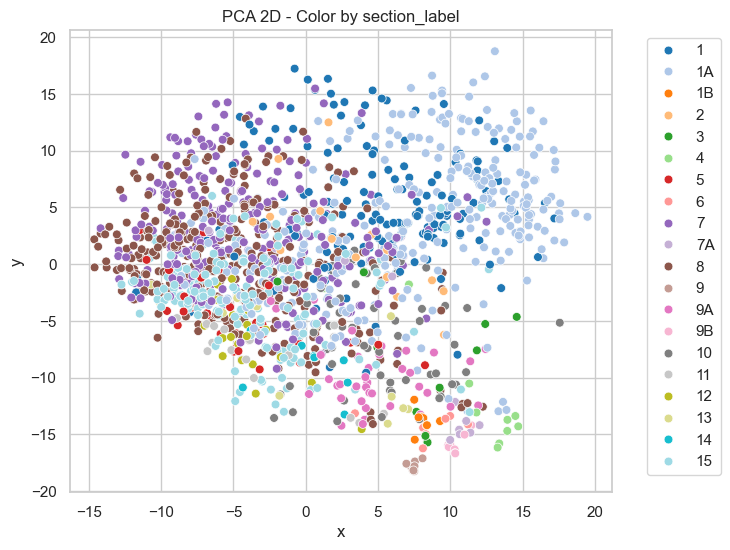

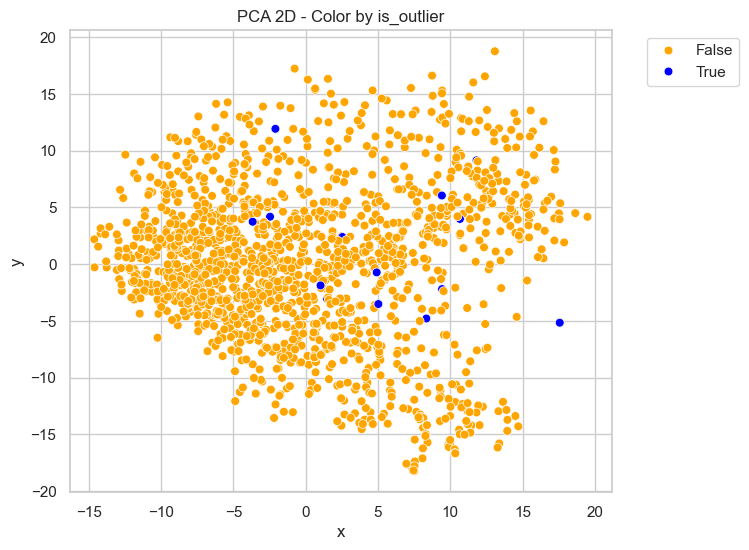

In [40]:
sns.set(style="whitegrid")

# A) Color by cluster_id
plt.figure(figsize=(7,6))
sns.scatterplot(data=pdf, x="x", y="y", hue="cluster_id", palette="tab20", s=40)
plt.title("PCA 2D - Color by cluster_id")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig("screenshots/pca_cluster_id.jpeg", dpi=300, bbox_inches='tight')
plt.show()

# B) Color by section_label
plt.figure(figsize=(7,6))
sns.scatterplot(data=pdf, x="x", y="y", hue="section_label", palette="tab20", s=40)
plt.title("PCA 2D - Color by section_label")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig("screenshots/pca_section_label.jpeg", dpi=300, bbox_inches='tight')
plt.show()

# C) Color by outlier
plt.figure(figsize=(7,6))
sns.scatterplot(data=pdf,x="x",y="y",hue="is_outlier_iqr",palette={True: "blue", False: "orange"},s=40)
plt.title("PCA 2D - Color by is_outlier")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig("screenshots/pca_is_outlier.jpeg", dpi=300, bbox_inches='tight')
plt.show()



In [41]:
def plot_clusters_sections(
    pdf,
    top_clusters=5,
    top_sections=5,
    save_fig=False,
    save_path="screenshots/plot_top_clusters_sections.jpeg"
):
    """
    Produce two side-by-side scatterplots in PCA 2D:
      Left: color by top clusters (others merged to 'OtherCluster')
      Right: color by top sections (others merged to 'OtherSection')
    """
    cluster_counts = pdf["cluster_id"].value_counts()
    top_cluster_set = set(cluster_counts.index[:top_clusters])
    
    def reduce_cluster(cid):
        return cid if cid in top_cluster_set else "OtherCluster"
    pdf["cluster_reduced"] = pdf["cluster_id"].apply(reduce_cluster)
    
    if "section_label" not in pdf.columns:
        pdf["section_label"] = pdf["chunk_col_name"].apply(extract_section)

    section_counts = pdf["section_label"].value_counts()
    top_section_set = set(section_counts.index[:top_sections])
    
    def reduce_section(sec):
        return sec if sec in top_section_set else "OtherSection"
    pdf["section_reduced"] = pdf["section_label"].apply(reduce_section)

    # Define palettes so "Other*" is a light color
    uniq_clusters = sorted(pdf["cluster_reduced"].unique(), key=lambda x: (x != "OtherCluster", x))
    main_clusters = [c for c in uniq_clusters if c != "OtherCluster"]
    cluster_colors = sns.color_palette("tab10", n_colors=len(main_clusters))

    cluster_palette = {}
    color_idx = 0
    for c in uniq_clusters:
        if c == "OtherCluster":
            cluster_palette[c] = "#DDDDDD"
        else:
            cluster_palette[c] = cluster_colors[color_idx]
            color_idx += 1

    uniq_sections = sorted(pdf["section_reduced"].unique(), key=lambda x: (x != "OtherSection", x))
    main_sections = [s for s in uniq_sections if s != "OtherSection"]
    section_colors = sns.color_palette("tab10", n_colors=len(main_sections))

    section_palette = {}
    color_idx = 0
    for s in uniq_sections:
        if s == "OtherSection":
            section_palette[s] = "#DDDDDD"
        else:
            section_palette[s] = section_colors[color_idx]
            color_idx += 1

    # Plot side-by-side
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Left: color by cluster_reduced
    sns.scatterplot(
        ax=axes[0],
        data=pdf,
        x="x",
        y="y",
        hue="cluster_reduced",
        palette=cluster_palette,
        s=40
    )
    axes[0].set_title(f"Top {top_clusters} Clusters + 'OtherCluster'")
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

    # Right: color by section_reduced
    sns.scatterplot(
        ax=axes[1],
        data=pdf,
        x="x",
        y="y",
        hue="section_reduced",
        palette=section_palette,
        s=40
    )
    axes[1].set_title(f"Top {top_sections} Sections + 'OtherSection'")
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

    plt.tight_layout()
    if save_fig:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Image saved to {save_path}")
    plt.show()

Image saved to screenshots/plot_top_clusters_sections.jpeg


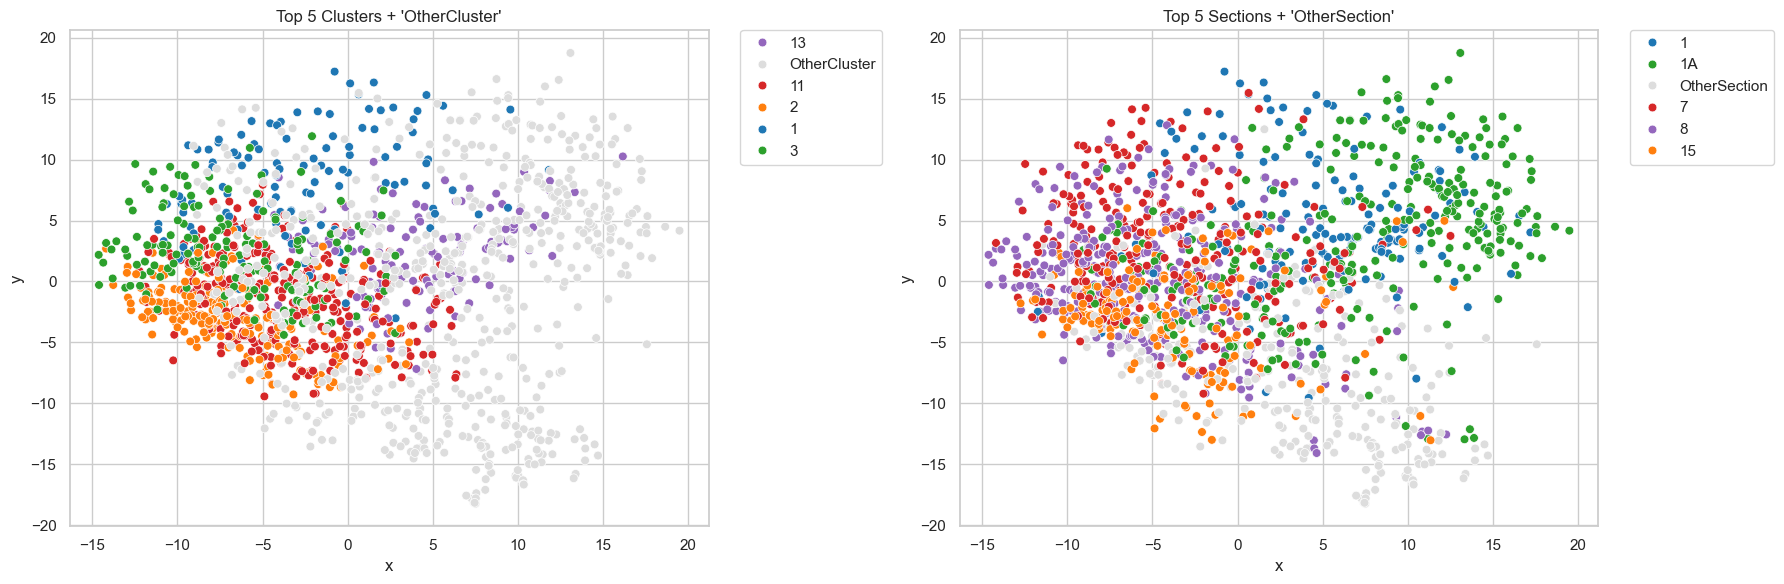

In [42]:
plot_clusters_sections(pdf, top_clusters=5, top_sections=5, save_fig=True)

In [43]:
# Stop Spark
spark.stop()

# Summary

In this task, despite using the BGE model specialized for financial contexts and applying PCA for dimensionality reduction, the performance of KMeans clustering was suboptimal, and visulization split is not clear. Even at the best k=18, the silhouette score remained around 0.1. This suggests that the data may not exhibit a clear clustering structure or is influenced by noise, inadequate feature representation, and other factors.

# **Potential Issues:**

1. **Noise Factors**  
   - The parsing of the raw data was relatively coarse, failing to preserve key structural elements from 10-K reports (such as heading hierarchies and tables). This resulted in significant loss of contextual information and introduced noise into the dataset.

2. **Feature Representation**  
   - Although I use the `e5-large` model which has a very big para size, due to time and computational constraints, I'm unable to fine-tune it further or experiment with more powerful/suitable models. As a result, the model may not have effectively captured key textual information.
   - PCA is a linear dimensionality reduction technique, which may not be well-suited for capturing complex nonlinear structures in textual features. Exploring the latent space in encoder-decoder architectures (bottleneck representations) could be a more effective approach for dimensionality reduction.

3. **Chunking Strategy**  
   - Ideally, each section should be treated as an independent document before further segmentation based on semantic meaning to retain as much structural and contextual information as possible. Due to time constraints, only a coarse chunking approach was applied in this experiment. Future work could explore more advanced semantic chunking strategies, such as [LlamaIndex Semantic Chunking](https://docs.llamaindex.ai/en/stable/examples/node_parsers/semantic_chunking/), to reduce unnecessary noise and improve the interpretability of text segments.
